In [55]:
import coffea
import mplhep
import os

In [25]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor
import hist
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from pprint import pprint
import numba

import mplhep as hep
hep.style.use(hep.style.ROOT)


In [19]:
filename = "/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1000.root"
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events

<NanoEventsArray [<event 1:1:1>, ... <event 1:1:3000>] type='3000 * event'>

In [ ]:
jets_mask = (abs(events.Jet.eta)<2.4) & (events.Jet.pt>30)
plt.hist(ak.num(events.Jet), bins=30, range=(0, 30), histtype="step", label="inclusive")
plt.hist(ak.num(events.Jet[events.Jet.pt>30]),bins=30, range=(0, 30), histtype="step",label="pt>30")
plt.hist(ak.num(events.Jet[jets_mask]),bins=30, range=(0, 30), histtype="step",label="pt>30 eta<2.4")
plt.legend()
plt.xlabel("N. jets")
hep.cms.label(rlabel="13.6 TeV", loc=0) 

In [20]:
higgs = events.LHEPart[(events.LHEPart.status==1)&(events.LHEPart.pdgId==25)]

In [21]:
higgs.pt

<Array [[186], [136], ... [84], [192]] type='3000 * var * float32[parameters={"_...'>

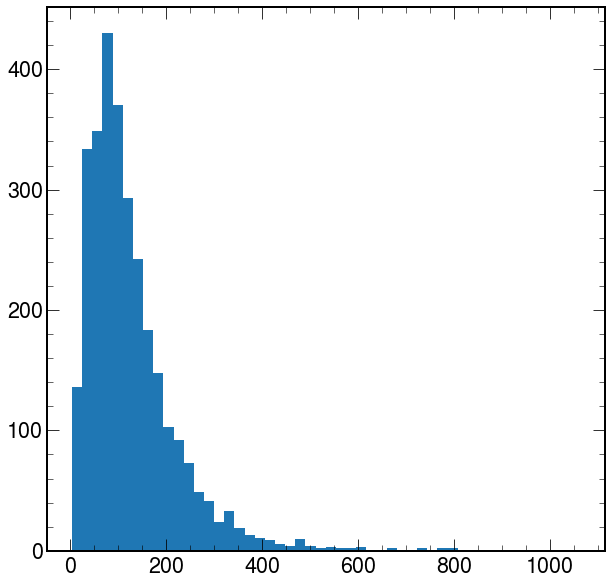

In [14]:
plt.hist(higgs.pt, bins=50);

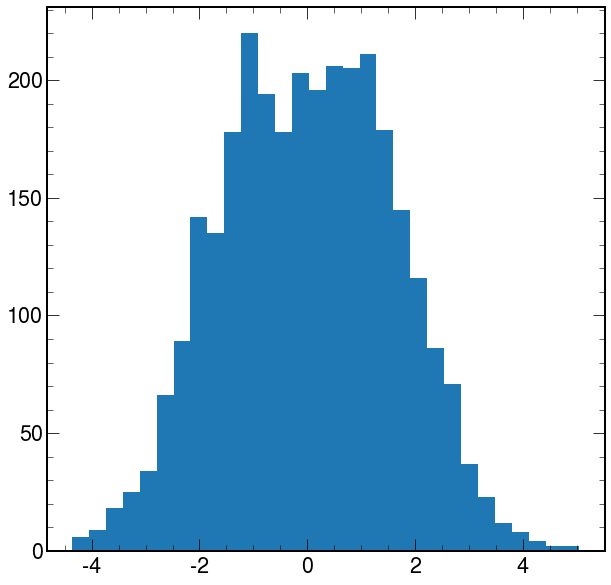

In [15]:
plt.hist(higgs.eta, bins=30);

In [136]:
semilep_lhe = ak.sum( (abs(events.LHEPart.pdgId) >=11)&(abs(events.LHEPart.pdgId) <17), axis=1)==2
dilep_lhe = ak.sum( (abs(events.LHEPart.pdgId) >=11)&(abs(events.LHEPart.pdgId) <17), axis=1)==4
had_lhe = ak.sum( (abs(events.LHEPart.pdgId) >=11)&(abs(events.LHEPart.pdgId) <17), axis=1)==0
notau = ak.sum(abs(events.LHEPart.pdgId) == 15, axis=1)==0

In [138]:
events_semilep = events[semilep_lhe&notau]
events_dilep = events[dilep_lhe&notau]
events_had = events[had_lhe&notau]

In [139]:
tot = len(events)
print(f"% semilep: {len(events_semilep)/tot:.2f}")
print(f"% dilep: {len(events_dilep)/tot:.2f}")
print(f"% had: {len(events_had)/tot:.2f}")

% semilep: 0.29
% dilep: 0.04
% had: 0.47


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

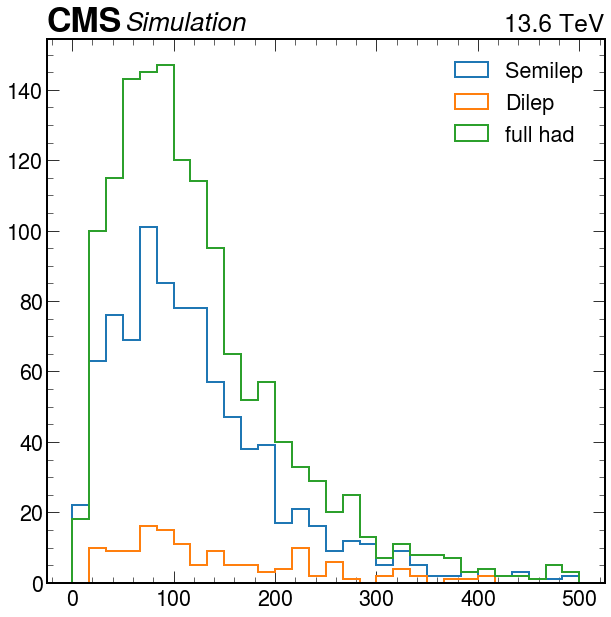

In [107]:
plt.hist(higgs[semilep_lhe&notau].pt, bins=30, range=(0,500), linewidth=2, histtype="step", label="Semilep")
plt.hist(higgs[dilep_lhe&notau].pt, bins=30, range=(0,500), linewidth=2, histtype="step", label="Dilep")
plt.hist(higgs[had_lhe&notau].pt, bins=30, range=(0,500), linewidth=2, histtype="step", label="full had")
plt.legend()
hep.cms.label(rlabel="13.6 TeV", loc=0) 

# Adding kin variables

In [161]:
leptons = ak.with_name(
            ak.concatenate((events.Muon, events.Electron), axis=1),
            name='PtEtaPhiMCandidate',
        )
events["Lepton"] = leptons[ak.argsort(leptons.pt, ascending=False)]

events["recoHT"] = ak.sum(events.Jet.pt, axis=1)  + ak.sum(events.Lepton.pt, axis=1) + events.MET.pt

(array([ 15., 170., 519., 767., 615., 351., 216., 134.,  79.,  53.,  24.,
         21.,  15.,   6.,   6.,   2.,   5.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
        1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600.,
        2700., 2800., 2900., 3000., 3100., 3200., 3300., 3400., 3500.,
        3600., 3700., 3800., 3900., 4000., 4100., 4200., 4300., 4400.,
        4500., 4600., 4700., 4800., 4900., 5000.]),
 <BarContainer object of 50 artists>)

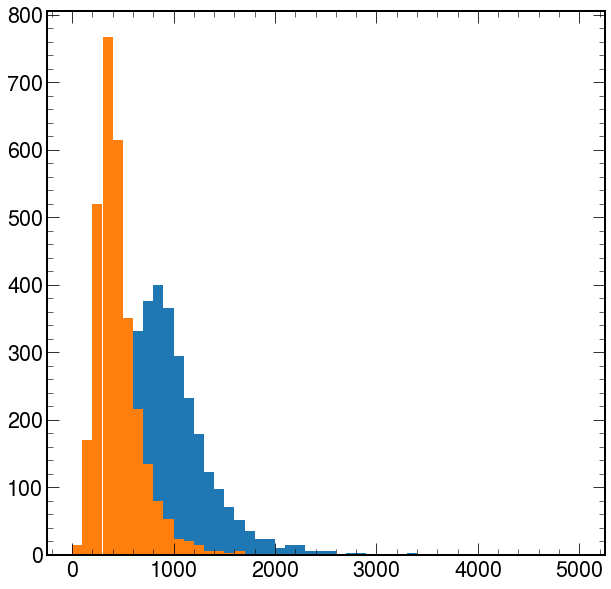

In [165]:
plt.hist(events.recoHT, bins=50, range=(0, 5000))
plt.hist(events.LHE.HT, bins=50, range=(0, 5000))

# Trigger selection

In [166]:
single_lep_HLT = ["Ele32_WPTight_Gsf", "Ele28_eta2p1_WPTight_Gsf_HT150", "IsoMu24"]
new_triggers = ["PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepJet_4p5",
               "PFHT340_QuadPFJet70_50_40_40_PNet2BTagMean0p70",
               "PFHT280_QuadPFJet30_PNet2BTagMean0p55"]

newtrig_hlt = [events.HLT[trig] for trig in new_triggers]

single_lep_hlt =  ak.from_numpy(np.zeros(len(events), dtype="bool"))
for trig in single_lep_HLT: 
    single_lep_hlt = single_lep_hlt | events.HLT[trig]

In [141]:
print(list(filter(lambda k: "Ele32" in k, events.HLT.fields)))
print(list(filter(lambda k: "Ele28" in k, events.HLT.fields)))
print(list(filter(lambda k: "IsoMu" in k, events.HLT.fields)))
print(list(filter(lambda k: "PNet" in k, events.HLT.fields)))
print(list(filter(lambda k: "PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepJet_4p5" in k, events.HLT.fields)))


['Ele32_WPTight_Gsf', 'Ele32_WPTight_Gsf_L1DoubleEG']
['Ele28_eta2p1_WPTight_Gsf_HT150', 'Ele28_HighEta_SC20_Mass55']
['IsoMu27_MediumDeepTauPFTauHPS20_eta2p1_SingleL1', 'IsoMu20', 'IsoMu24', 'IsoMu24_eta2p1', 'IsoMu27', 'IsoMu24_TwoProngs35', 'DoubleIsoMu20_eta2p1', 'IsoMu20_eta2p1_LooseDeepTauPFTauHPS27_eta2p1_CrossL1', 'IsoMu24_eta2p1_LooseDeepTauPFTauHPS180_eta2p1', 'IsoMu24_eta2p1_LooseDeepTauPFTauHPS30_eta2p1_CrossL1', 'IsoMu24_eta2p1_MediumDeepTauPFTauHPS35_L2NN_eta2p1_CrossL1', 'IsoMu50_AK8PFJet220_SoftDropMass40', 'IsoMu50_AK8PFJet220_SoftDropMass40_PNetBB0p06', 'IsoMu50_AK8PFJet230_SoftDropMass40', 'IsoMu50_AK8PFJet230_SoftDropMass40_PNetBB0p06', 'IsoMu50_AK8PFJet230_SoftDropMass40_PNetBB0p10', 'IsoMu24_eta2p1_MediumDeepTauPFTauHPS30_L2NN_eta2p1_CrossL1', 'IsoMu24_eta2p1_MediumDeepTauPFTauHPS30_L2NN_eta2p1_PFJet60_CrossL1', 'IsoMu24_eta2p1_MediumDeepTauPFTauHPS30_L2NN_eta2p1_PFJet75_CrossL1', 'IsoMu24_eta2p1_MediumDeepTauPFTauHPS20_eta2p1_SingleL1', 'IsoMu24_eta2p1_MediumDeep

(array([10., 30., 47., 34., 52., 40., 37., 43., 31., 22., 21., 16.,  8.,
        15., 11.,  5.,  5.,  8.,  1.,  4.,  1.,  0.,  1.,  1.,  2.,  1.,
         1.,  1.,  1.,  0.]),
 array([  0.        ,  16.66666603,  33.33333206,  50.        ,
         66.66666412,  83.33333588, 100.        , 116.66666412,
        133.33332825, 150.        , 166.66667175, 183.33332825,
        200.        , 216.66667175, 233.33332825, 250.        ,
        266.66665649, 283.33334351, 300.        , 316.66665649,
        333.33334351, 350.        , 366.66665649, 383.33334351,
        400.        , 416.66665649, 433.33334351, 450.        ,
        466.66665649, 483.33334351, 500.        ]),
 [<matplotlib.patches.Polygon at 0x7fb16d1cd4f0>])

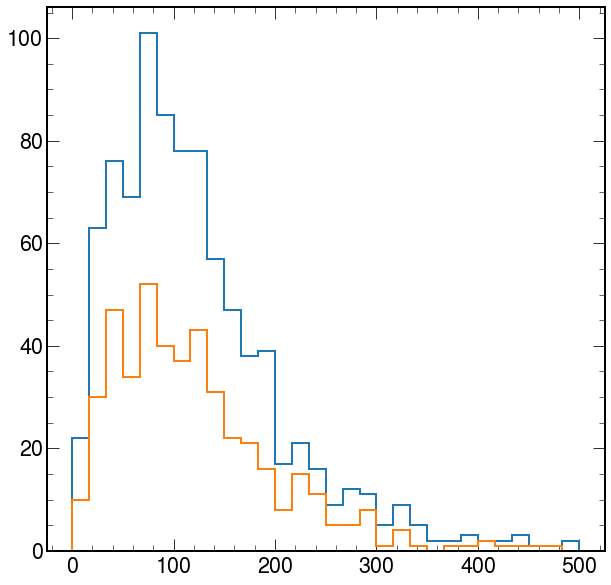

In [144]:
plt.hist(higgs[semilep_lhe&notau].pt, bins=30, range=(0,500), linewidth=2, histtype="step", label="Semilep")
plt.hist(higgs[semilep_lhe &notau & single_lep_hlt].pt, bins=30, range=(0,500), linewidth=2, histtype="step", label="Single lep trigger")

In [145]:
def plot_comparison(dfB, dfA, var, label, bins, xrange, output_folder, 
                    ylog=False, wA=None, wB=None, flatten=False,density=False,
                    legendB="Mustache", legendA="DeepSC", text=None, ratio_lim=(0.8,1.2),
                   texty=.75, rlabel="13.6 TeV",llabel="Simulation Preliminary"):
    
    fig = plt.figure(figsize=(10,11), dpi=72)
    gs = fig.add_gridspec(2,1, height_ratios=[0.75,0.25])
    plt.subplots_adjust(hspace=0.08)
    axs = gs.subplots(sharex=True)
    
    ax =  axs[0]
    axr =  axs[1]
    
    if flatten:
        dfA = ak.flatten(dfA)
        dfB = ak.flatten(dfB)
    
    B, binX, _ = ax.hist(dfB, bins=bins, range=xrange,  weights=wB,
                         label=legendB, histtype="step", linewidth=2, density=density)
    A, binX, _ = ax.hist(dfA, bins=bins, range=xrange, weights=wA,
                         label=legendA, histtype="step", linewidth=2, density=density)
    
    print("B:", np.sum(B))
    print("A.", np.sum(A))
    
    if density:
        errA,_ = np.histogram(dfA, bins=bins, range=xrange, weights=wA)
        errB,_ = np.histogram(dfB, bins=bins, range=xrange, weights=wB)
    else:
        errA = np.sqrt(A)
        errB = np.sqrt(B)

    ax.legend()
    axr.set_xlabel(label)
    
    if text!=None:
        ax.text(0.07, texty, text, transform=ax.transAxes, fontsize="small")
        
    hep.cms.label(llabel=llabel, rlabel=rlabel, loc=0, ax=ax)
    
   
    mmax = max([max(A), max(B)])
    if ylog:
        ax.set_ylim(max([min(A), min(B),1e-3]), mmax*300)
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, mmax*1.4)
         

    errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)

    ratio= np.where( (A>0)&(B>0),
                     A/B,
                     1.) 
    
    centers = (np.roll(binX, -1) + binX)/2
 
    axr.errorbar(centers[:-1], ratio, xerr=0, yerr=errR,
                                fmt=".", linestyle='none', elinewidth=1, c="black")
    
    if ratio_lim =="auto":
        deltaMax = max([np.max(ratio), 1.1])
        deltaMin = min([np.min(ratio), 0.9])

        #print(deltaM)
        axr.set_ylim(max(0, deltaMin*0.9), deltaMax*1.1)
    else:
        axr.set_ylim(*ratio_lim)
    axr.set_ylabel("ratio")
    axr.grid(which="both",axis="y")
    axr.plot([binX[0], binX[-1]], [1.,1.], linewidth=2, c="black")

    if output_folder!=None:
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + f"/{var}_comparison.png")
        fig.savefig(output_folder + f"/{var}_comparison.pdf")
        fig.savefig(output_folder + f"/{var}_comparison.svg")

B: 876.0
A. 449.0


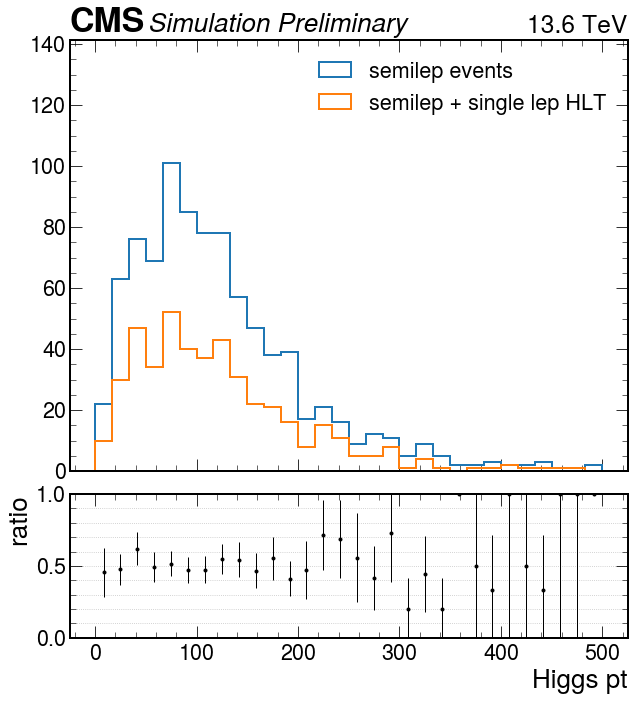

In [146]:
B = higgs[semilep_lhe&notau].pt
A = higgs[semilep_lhe&notau & single_lep_hlt].pt

plot_comparison(B, A, "higgs_pt", "Higgs pt", bins=30, xrange=(0, 500), output_folder=None,
               legendB="semilep events", 
               legendA="semilep + single lep HLT",
               ratio_lim=(0,1))

(array([108., 227., 218., 161.,  92.,  63.,   8.,   2.,   1.,   3.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

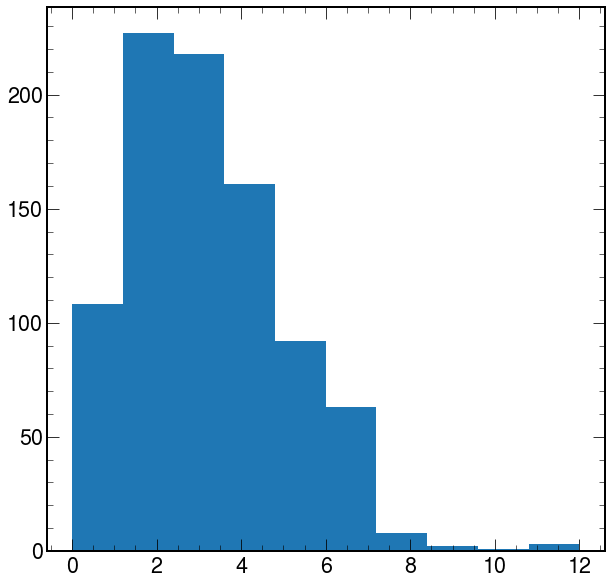

In [148]:
plt.hist(ak.num(events[semilep_lhe&notau].Lepton))

In [127]:
jets4_mask

<Array [True, True, True, ... True, True, True] type='3000 * bool'>

B: 804.0
A. 424.0


/tmp/ipykernel_1197/2582234524.py:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_1197/2582234524.py:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_1197/2582234524.py:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_1197/2582234524.py:53: RuntimeWarning: invalid value encountered in divide
  A/B,


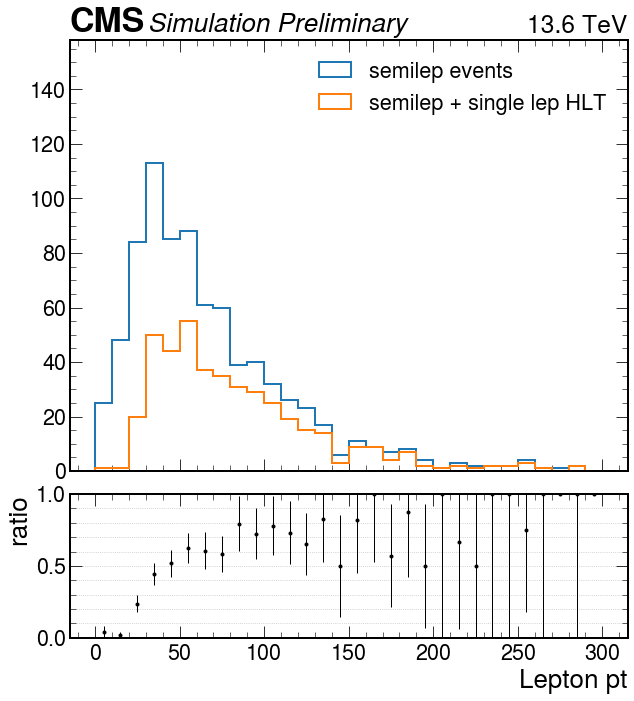

In [149]:
onelep = ak.num(events.Lepton.pt>25)>0
jets4_mask = ak.sum(jets_mask, axis=1)>=4

B = events[semilep_lhe&notau&onelep&jets4_mask].Lepton.pt[:,0]
A = events[semilep_lhe&notau&onelep&jets4_mask&single_lep_hlt].Lepton.pt[:,0]

plot_comparison(B, A, "lepton_pt", "Lepton pt", bins=30, xrange=(0, 300), output_folder=None,
               legendB="semilep events", 
               legendA="semilep + single lep HLT",
               ratio_lim=(0,1))

B: 840.0
A. 434.0


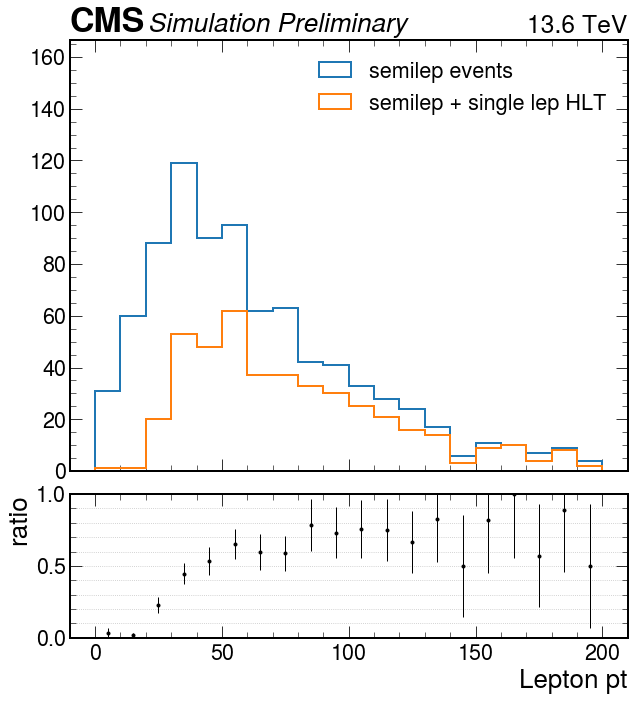

In [173]:
onelep = (ak.num(events.Lepton.pt>15)>0)
jets4_mask = ak.sum(jets_mask, axis=1)>=4

B = events[semilep_lhe&notau&onelep].Lepton.pt[:,0]
A = events[semilep_lhe&notau&onelep& (single_lep_hlt)].Lepton.pt[:,0]

plot_comparison(B, A, "lepton_pt", "Lepton pt", bins=20, xrange=(0, 200), output_folder=None,
               legendB="semilep events", 
               legendA="semilep + single lep HLT",
               ratio_lim=(0,1))

B: 840.0
A. 564.0


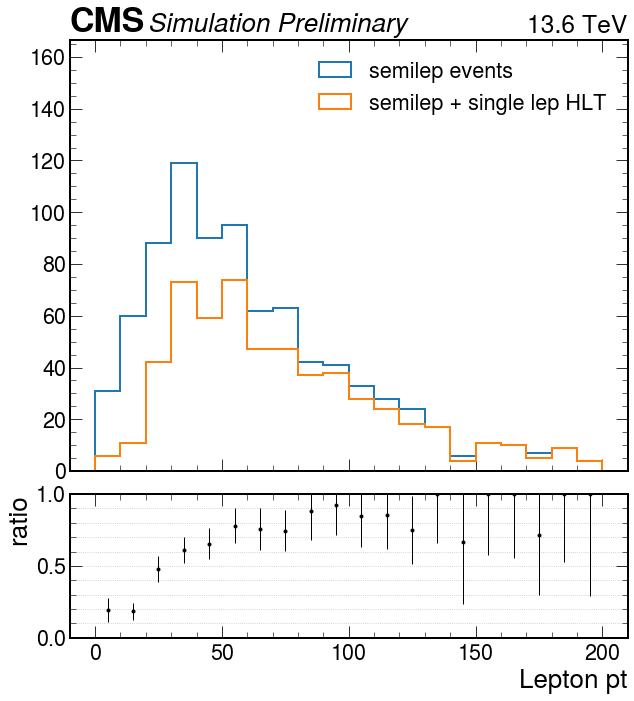

In [185]:
onelep = (ak.num(events.Lepton.pt>15)>0)
jets4_mask = ak.sum(jets_mask, axis=1)>=4

B = events[semilep_lhe&notau&onelep].Lepton.pt[:,0]
A = events[semilep_lhe&notau&onelep& (newtrig_hlt[0]|single_lep_hlt)].Lepton.pt[:,0]

plot_comparison(B, A, "lepton_pt", "Lepton pt", bins=20, xrange=(0, 200), output_folder=None,
               legendB="semilep events", 
               legendA="semilep + single lep HLT",
               ratio_lim=(0,1))

In [153]:
abs(events.Lepton.eta[:,0])<1.5

ValueError: in ListOffsetArray64 attempting to get 0, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/cpu-kernels/awkward_NumpyArray_getitem_next_at.cpp#L21)

B: 809.0
A. 424.0


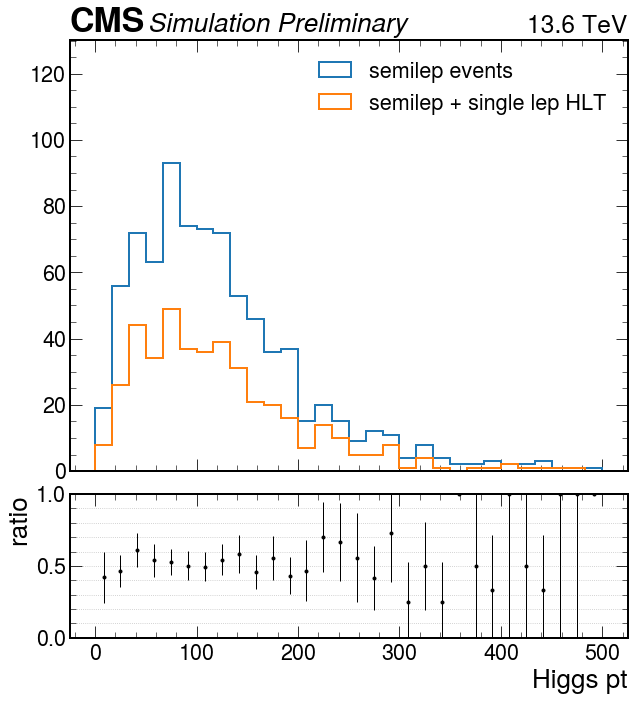

In [174]:
onelep = (ak.num(events.Lepton.pt>15)>0)
jets4_mask = ak.sum(jets_mask, axis=1)>=4

B = higgs[semilep_lhe&notau&onelep&jets4_mask].pt
A = higgs[semilep_lhe&notau&onelep&jets4_mask & single_lep_hlt].pt

plot_comparison(B, A, "higgs_pt", "Higgs pt", bins=30, xrange=(0, 500), output_folder=None,
               legendB="semilep events", 
               legendA="semilep + single lep HLT",
               ratio_lim=(0,1))

B: 809.0
A. 694.0


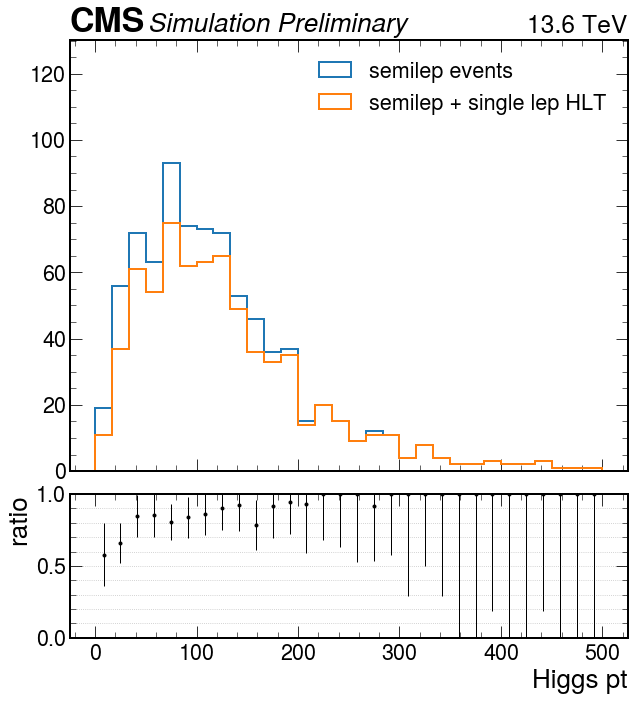

In [177]:
onelep = (ak.num(events.Lepton.pt>15)>0)
jets4_mask = ak.sum(jets_mask, axis=1)>=4

B = higgs[semilep_lhe&notau&onelep&jets4_mask].pt
A = higgs[semilep_lhe&notau&onelep&jets4_mask & (single_lep_hlt|newtrig_hlt[2])].pt

plot_comparison(B, A, "higgs_pt", "Higgs pt", bins=30, xrange=(0, 500), output_folder=None,
               legendB="semilep events", 
               legendA="semilep + single lep HLT",
               ratio_lim=(0,1))

In [178]:
import hist

Hist(Regular(50, 0, 2000, name='HT'), storage=Double()) # Sum: 2999.0 (3000.0 with flow)

In [55]:
events.genWeight

<Array [0.586, 0.586, 0.586, ... 0.586, 0.586] type='3000 * float32[parameters={...'>

In [79]:
class Processor(processor.ProcessorABC):
    def __init__(self):
        pass
    
    def process(self, events):
        
        jets_mask = (abs(events.Jet.eta)<2.4) & (events.Jet.pt>30)
        higgs = events.LHEPart[(events.LHEPart.status==1)&(events.LHEPart.pdgId==25)]
        leptons = ak.with_name(
            ak.concatenate((events.Muon, events.Electron), axis=1),
            name='PtEtaPhiMCandidate',
        )
        events["Lepton"] = leptons[ak.argsort(leptons.pt, ascending=False)]

        semilep_lhe = ak.sum( (abs(events.LHEPart.pdgId) >=11)&(abs(events.LHEPart.pdgId) <17), axis=1)==2
        dilep_lhe = ak.sum( (abs(events.LHEPart.pdgId) >=11)&(abs(events.LHEPart.pdgId) <17), axis=1)==4
        had_lhe = ak.sum( (abs(events.LHEPart.pdgId) >=11)&(abs(events.LHEPart.pdgId) <17), axis=1)==0
    
        notau = ak.sum(abs(events.LHEPart.pdgId) == 15, axis=1)==0
        
        onelep = (ak.num(events.Lepton.pt>15)>0)
        jets4_mask = ak.sum(jets_mask, axis=1)>=4
        single_lep_HLT = ["Ele32_WPTight_Gsf", "Ele28_eta2p1_WPTight_Gsf_HT150", "IsoMu24"]
        new_triggers = ["PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepJet_4p5",
               "PFHT340_QuadPFJet70_50_40_40_PNet2BTagMean0p70",
               "PFHT280_QuadPFJet30_PNet2BTagMean0p55"]

        newtrig_hlt = [events.HLT[trig] for trig in new_triggers]

        single_lep_hlt =  ak.from_numpy(np.zeros(len(events), dtype="bool"))
        for trig in single_lep_HLT: 
            single_lep_hlt = single_lep_hlt | events.HLT[trig]
        
    
        
        return {  
            "semilep_incl_HT": hist.Hist(hist.axis.Regular(name="HT", bins=50, start=0, stop=1200), storage="weight").fill(events[semilep_lhe&notau].LHE.HT, weight=events[semilep_lhe&notau].genWeight),
            "semilep_accep_HT": hist.Hist(hist.axis.Regular(name="HT", bins=50, start=0, stop=1200,),storage="weight").fill(events[semilep_lhe&notau&jets4_mask&onelep].LHE.HT, 
                                                                                                                            weight=events[semilep_lhe&notau&jets4_mask&onelep].genWeight),
            "semilep_singleleHLT_HT": hist.Hist(hist.axis.Regular(name="HT", bins=50, start=0, stop=1200),storage="weight").fill(events[semilep_lhe & notau & jets4_mask & onelep & single_lep_hlt].LHE.HT,
                                                                                                                                weight=events[semilep_lhe & notau & jets4_mask & onelep & single_lep_hlt].genWeight),
            "semilep_newtrig1_HT": hist.Hist(hist.axis.Regular(name="HT", bins=50, start=0, stop=1200),storage="weight").fill(events[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[0])].LHE.HT,
                                                                                                                             weight=events[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[0])].genWeight),
            "semilep_newtrig2_HT": hist.Hist(hist.axis.Regular(name="HT", bins=50, start=0, stop=1200),storage="weight").fill(events[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[1])].LHE.HT,
                                                                                                                             weight=events[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[1])].genWeight),
            "semilep_newtrig3_HT": hist.Hist(hist.axis.Regular(name="HT", bins=50, start=0, stop=1200),storage="weight").fill(events[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[2])].LHE.HT,
                                                                                                                             weight=events[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[2])].genWeight),
            
            "semilep_incl_higgspt": hist.Hist(hist.axis.Regular(name="higgs_pt", bins=50, start=0, stop=500),storage="weight").fill(higgs[semilep_lhe&notau].pt[:,0],
                                                                                                                             weight=events[semilep_lhe&notau].genWeight),
            "semilep_accep_higgspt": hist.Hist(hist.axis.Regular(name="higgs_pt", bins=50, start=0, stop=500),storage="weight").fill(higgs[semilep_lhe&notau&jets4_mask&onelep].pt[:,0],
                                                                                                                                weight=events[semilep_lhe&notau&jets4_mask&onelep].genWeight),
            "semilep_singleleHLT_higgspt": hist.Hist(hist.axis.Regular(name="higgs_pt", bins=50, start=0, stop=500),storage="weight").fill(higgs[semilep_lhe & notau & jets4_mask & onelep & single_lep_hlt].pt[:,0],
                                                                                                                                weight=events[semilep_lhe & notau & jets4_mask & onelep & single_lep_hlt].genWeight),
            "semilep_newtrig1_higgspt": hist.Hist(hist.axis.Regular(name="higgs_pt", bins=50, start=0, stop=500),storage="weight").fill(higgs[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[0])].pt[:,0],
                                                                                                                                weight=events[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[0])].genWeight),
            "semilep_newtrig2_higgspt": hist.Hist(hist.axis.Regular(name="higgs_pt", bins=50, start=0, stop=500),storage="weight").fill(higgs[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[1])].pt[:,0],
                                                                                                                                weight=events[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[1])].genWeight),
            
            "semilep_newtrig3_higgspt": hist.Hist(hist.axis.Regular(name="higgs_pt", bins=50, start=0, stop=500),storage="weight").fill(higgs[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[2])].pt[:,0],
                                                                                                                              weight=events[semilep_lhe&notau&jets4_mask&onelep& (single_lep_hlt | newtrig_hlt[2])].genWeight),
            
            
            "had_incl_HT": hist.Hist(hist.axis.Regular(name="HT", bins=50, start=0, stop=1200), storage="weight").fill(events[had_lhe&notau].LHE.HT, weight=events[had_lhe&notau].genWeight),
            "had_accep_HT": hist.Hist(hist.axis.Regular(name="HT", bins=50, start=0, stop=1200,),storage="weight").fill(events[had_lhe&notau&jets4_mask].LHE.HT, 
                                                                                                                            weight=events[had_lhe&notau&jets4_mask].genWeight),
            "had_newtrig1_HT": hist.Hist(hist.axis.Regular(name="HT", bins=50, start=0, stop=1200),storage="weight").fill(events[had_lhe&notau&jets4_mask&(newtrig_hlt[0])].LHE.HT,
                                                                                                                             weight=events[had_lhe&notau&jets4_mask& ( newtrig_hlt[0])].genWeight),
            "had_newtrig2_HT": hist.Hist(hist.axis.Regular(name="HT", bins=50, start=0, stop=1200),storage="weight").fill(events[had_lhe&notau&jets4_mask& ( newtrig_hlt[1])].LHE.HT,
                                                                                                                             weight=events[had_lhe&notau&jets4_mask& ( newtrig_hlt[1])].genWeight),
            "had_newtrig3_HT": hist.Hist(hist.axis.Regular(name="HT", bins=50, start=0, stop=1200),storage="weight").fill(events[had_lhe&notau&jets4_mask& ( newtrig_hlt[2])].LHE.HT,
                                                                                                                             weight=events[had_lhe&notau&jets4_mask& ( newtrig_hlt[2])].genWeight),
            
            "had_incl_higgspt": hist.Hist(hist.axis.Regular(name="higgs_pt", bins=50, start=0, stop=500),storage="weight").fill(higgs[had_lhe&notau].pt[:,0],
                                                                                                                             weight=events[had_lhe&notau].genWeight),
            "had_accep_higgspt": hist.Hist(hist.axis.Regular(name="higgs_pt", bins=50, start=0, stop=500),storage="weight").fill(higgs[had_lhe&notau&jets4_mask].pt[:,0],
                                                                                                                                weight=events[had_lhe&notau&jets4_mask].genWeight),
            "had_newtrig1_higgspt": hist.Hist(hist.axis.Regular(name="higgs_pt", bins=50, start=0, stop=500),storage="weight").fill(higgs[had_lhe&notau&jets4_mask& (newtrig_hlt[0])].pt[:,0],
                                                                                                                                weight=events[had_lhe&notau&jets4_mask& (newtrig_hlt[0])].genWeight),
            "had_newtrig2_higgspt": hist.Hist(hist.axis.Regular(name="higgs_pt", bins=50, start=0, stop=500),storage="weight").fill(higgs[had_lhe&notau&jets4_mask& (newtrig_hlt[1])].pt[:,0],
                                                                                                                                weight=events[had_lhe&notau&jets4_mask& ( newtrig_hlt[1])].genWeight),
            
            "had_newtrig3_higgspt": hist.Hist(hist.axis.Regular(name="higgs_pt", bins=50, start=0, stop=500),storage="weight").fill(higgs[had_lhe&notau&jets4_mask& (newtrig_hlt[2])].pt[:,0],
                                                                                                                              weight=events[had_lhe&notau&jets4_mask& (newtrig_hlt[2])].genWeight),
            
        }
            
    
    
    def postprocess(self, accumulator):
        pass

In [1]:
from glob import glob
fileset = {
    "ttHbb": glob("/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/*.root", recursive=True)
}

In [2]:
fileset

{'ttHbb': ['/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1000.root',
  '/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1001.root',
  '/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1002.root',
  '/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1003.root',
  '/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1004.root',
  '/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1005.root',
  '/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1006.root',
  '/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1007.root',
  '/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1008.root',
  '/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1009.root',
  '/eos/user/m/mstamenk/CxAOD31run/trigger-run3/ttHbb/Run3Summer22NANOAODSIM_1010.root',
  '/eos/user

In [81]:
runner = processor.Runner(
     executor = processor.FuturesExecutor(compression=None, workers=4),
     schema=NanoAODSchema,
     chunksize=5000
)
out = runner(
     fileset,
     treename="Events",
     processor_instance=Processor(),
 )


Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95/95 [ 0:01:01 < 0:00:00 | 1.6  chunk/s ]
Merging (local) 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95/95 [ 0:01:01 < 0:00:00 | ?   merges/s ]

In [94]:
def hist_comparison(shapes, legends,  ylog=False, output_folder=None, yratio_lims=[0,1]):
    '''
    shapes = [(name)] 
    '''
    # os.makedirs(output_folder, exist_ok=True)
    # os.system(f"cp /eos/user/d/dvalsecc/www/index.php {output_folder}")
    
    fig = plt.figure(figsize=(8,9), dpi=100)
    gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.05, height_ratios=[0.7,0.3])
    axs = gs.subplots(sharex=True)
    plt.subplots_adjust(wspace=0.3)
    
    axu =  axs[0]
    axd =  axs[1]

    for H, leg in zip(shapes, legends):
        hep.histplot(H,  label=leg, ax=axu)
        
    if ylog:
        axu.set_yscale("log")
    axu.legend()
    axu.set_xlabel('')
    axu.set_ylabel('Events')
    #hep.plot.ylow(axu)
    #hep.plot.yscale_legend(axu)

    # Ratios
    nom = shapes[0]
    nomvalues = nom.values()
    nom_sig2 = nom.variances()
    centers = nom.axes[0].centers
    edges = nom.axes[0].edges
    minratio, maxratio = 1000.,0.
    for h, leg in zip(shapes, legends):
        h_val = h.values()
        h_sig2 = h.variances()
        
        err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
        r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
        m, M = np.min(r), np.max(r)
        if m < minratio: minratio = m
        if M > maxratio: maxratio = M
        axd.errorbar(centers, r, xerr=0, yerr=err, label=leg,
                     fmt=".", linestyle='none', elinewidth=1)
       
    axd.legend(ncol=3, fontsize='xx-small')
    hep.plot.yscale_legend(axd)
    axd.set_xlabel(nom.axes[0].label)
    axd.set_ylim(*yratio_lims)
    axd.set_ylabel("ratio")
    axd.grid(which="both",axis="y")
    
    axu.text(0.5, 1.025, "test tewst", transform=axu.transAxes, fontsize="x-small")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axu) 

In [91]:
out

{'semilep_incl_HT': Hist(Regular(50, 0, 1200, name='HT'), storage=Weight()) # Sum: WeightedSum(value=47615.5, variance=28534.2) (WeightedSum(value=47918.6, variance=28740.1) with flow),
 'semilep_accep_HT': Hist(Regular(50, 0, 1200, name='HT'), storage=Weight()) # Sum: WeightedSum(value=43646.3, variance=26166.5) (WeightedSum(value=43945.3, variance=26370) with flow),
 'semilep_singleleHLT_HT': Hist(Regular(50, 0, 1200, name='HT'), storage=Weight()) # Sum: WeightedSum(value=23017.4, variance=13797.5) (WeightedSum(value=23153.5, variance=13884.2) with flow),
 'semilep_newtrig1_HT': Hist(Regular(50, 0, 1200, name='HT'), storage=Weight()) # Sum: WeightedSum(value=30697.9, variance=18434) (WeightedSum(value=30931.3, variance=18593.5) with flow),
 'semilep_newtrig2_HT': Hist(Regular(50, 0, 1200, name='HT'), storage=Weight()) # Sum: WeightedSum(value=33565.5, variance=20159.9) (WeightedSum(value=33832.9, variance=20339.3) with flow),
 'semilep_newtrig3_HT': Hist(Regular(50, 0, 1200, name='HT

/tmp/ipykernel_2010/1460098839.py:38: RuntimeWarning: divide by zero encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_2010/1460098839.py:38: RuntimeWarning: invalid value encountered in multiply
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_2010/1460098839.py:38: RuntimeWarning: invalid value encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_2010/1460098839.py:39: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)


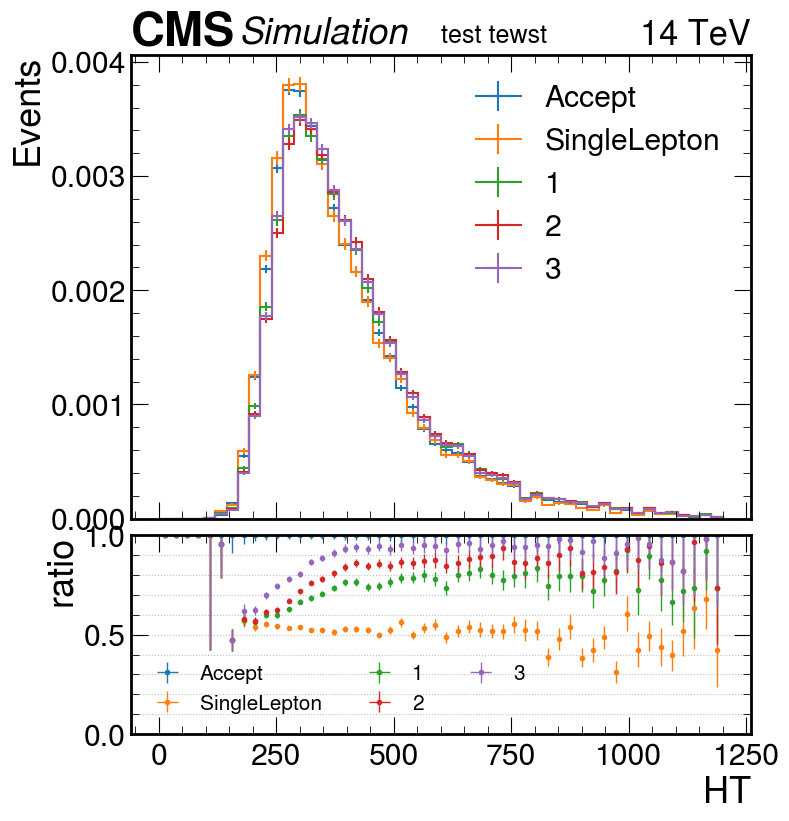

In [92]:
hist_comparison([
    out["semilep_accep_HT"],
    out["semilep_singleleHLT_HT"],
    out["semilep_newtrig1_HT"],
    out["semilep_newtrig2_HT"],
    out["semilep_newtrig3_HT"]
], ["Accept","SingleLepton", "1","2","3"],  ylog=False, )

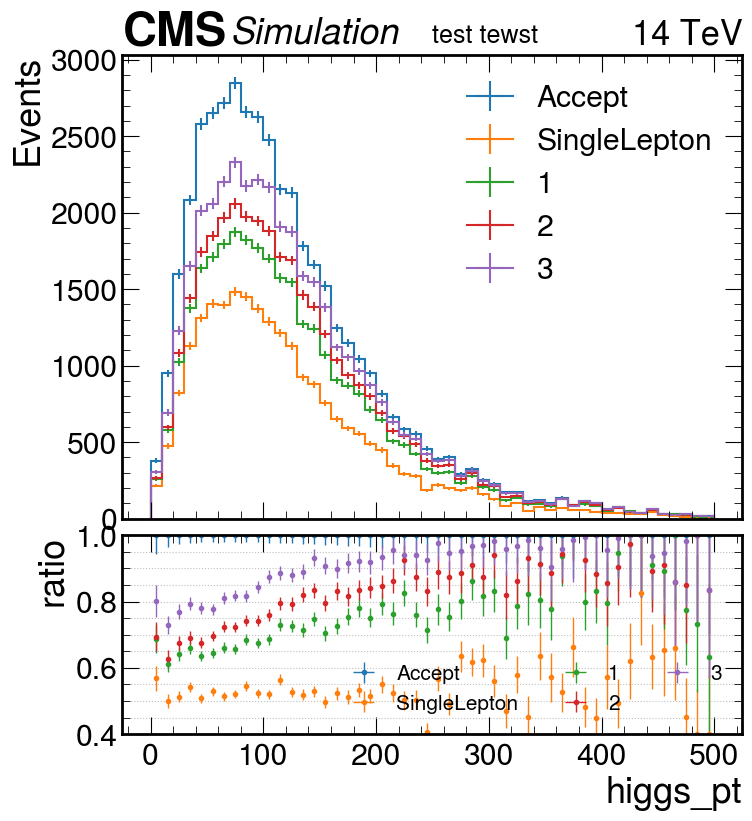

In [85]:
hist_comparison([
    out["semilep_accep_higgspt"],
    out["semilep_singleleHLT_higgspt"],
    out["semilep_newtrig1_higgspt"],
    out["semilep_newtrig2_higgspt"],
    out["semilep_newtrig3_higgspt"]
], ["Accept","SingleLepton", "1","2","3"],  ylog=False, )

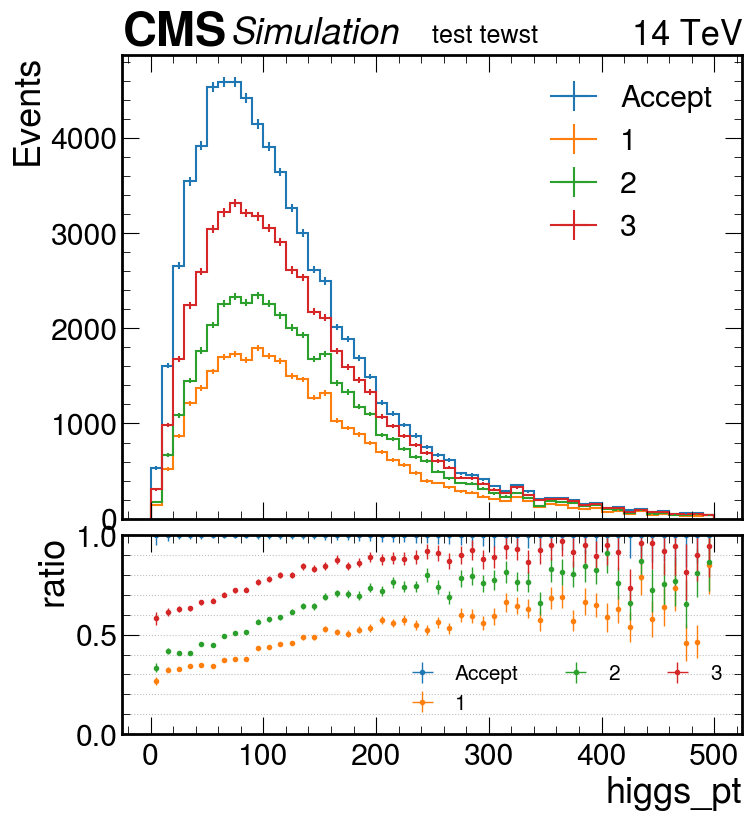

In [95]:
hist_comparison([
    out["had_accep_higgspt"],
    out["had_newtrig1_higgspt"],
    out["had_newtrig2_higgspt"],
    out["had_newtrig3_higgspt"]
], ["Accept","1","2","3"],  ylog=False)

# Analyzing coffea output

In [3]:
from coffea.util import load

In [41]:
df = load("output_all.coffea")

In [42]:
df["variables"]

{'higgs_pt': defaultdict(dict,
             {'ttHTobb': {'ttHTobb_Run3': Hist(
                 StrCategory(['had', 'had_doubleB_looser', 'had_doubleB_tighter', 'had_tripleB', 'inclusive', 'semilep', 'semilep_doubleB_looser', 'semilep_doubleB_looser+singleLep', 'semilep_doubleB_tighter', 'semilep_doubleB_tighter+singleLep', 'semilep_singlelepHLT', 'semilep_tripleB', 'semilep_tripleB+singleLep'], name='cat', label='Category'),
                 StrCategory(['nominal'], name='variation', label='Variation'),
                 Regular(30, 0, 400, name='higgs.pt', label='Higgs $p_T$'),
                 storage=Weight()) # Sum: WeightedSum(value=53237.9, variance=2882.11) (WeightedSum(value=54256, variance=2942.25) with flow)}}),
 'HT': defaultdict(dict,
             {'ttHTobb': {'ttHTobb_Run3': Hist(
                 StrCategory(['had', 'had_doubleB_looser', 'had_doubleB_tighter', 'had_tripleB', 'inclusive', 'semilep', 'semilep_doubleB_looser', 'semilep_doubleB_looser+singleLep', 'semilep_dou

In [76]:
def hist_comparison_2(Hs, cats, labels, file,  yratio_lim=[0,1],ylog=False, output_folder=None, ):
    # os.makedirs(output_folder, exist_ok=True)
    # os.system(f"cp /eos/user/d/dvalsecc/www/index.php {output_folder}")
    
    fig = plt.figure(figsize=(8,9), dpi=100)
    gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.05, height_ratios=[0.55,0.45])
    axs = gs.subplots(sharex=True)
    plt.subplots_adjust(wspace=0.3)
    
    axu =  axs[0]
    axd =  axs[1]

    for cat, label in zip(cats, labels):
        hep.histplot(Hs[cat, "nominal", :], label=label, ax=axu)
        
    if ylog:
        axu.set_yscale("log")
    axu.legend(fontsize=16)
    axu.set_xlabel('')
    axu.set_ylabel('Events')
    hep.plot.ylow(axu)
    hep.plot.yscale_legend(axu)

    # Ratios
    nom = Hs[cats[0], "nominal",:]
    nomvalues = nom.values()
    nom_sig2 = nom.variances()
    centers = nom.axes[0].centers
    edges = nom.axes[0].edges
    minratio, maxratio = 1000.,0.
    for cat in cats:
        h = Hs[cat, "nominal",:]
        h_val = h.values()
        h_sig2 = h.variances()
        
        err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
        r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
        m, M = np.min(r), np.max(r)
        if m < minratio: minratio = m
        if M > maxratio: maxratio = M
        axd.errorbar(centers, r, xerr=0, yerr=err,
                     fmt=".", linestyle='none', elinewidth=1)
       
    axd.legend(ncol=3, fontsize='xx-small')
    hep.plot.yscale_legend(axd)
    axd.set_xlabel(nom.axes[0].label)
    axd.set_ylim(*yratio_lim)
    axd.set_ylabel("efficiency")
    axd.grid(which="both",axis="y")
    
    hep.cms.label(rlabel="50/fb (13.6 TeV)", loc=0, ax=axu) 
    
    if output_folder: 
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(f"{output_folder}/{file}.png")
        fig.savefig(f"{output_folder}/{file}.pdf")
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


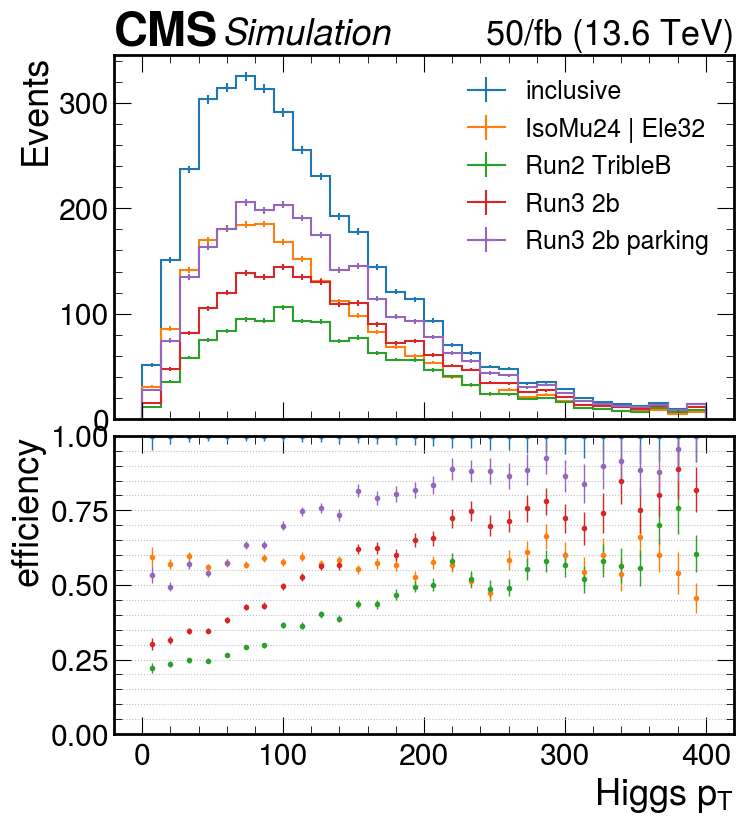

In [68]:
hist_comparison_2(df["variables"]["higgs_pt"]["ttHTobb"]["ttHTobb_Run3"], 
                ['semilep', 'semilep_singlelepHLT','semilep_tripleB', 
                 'semilep_doubleB_tighter', 'semilep_doubleB_looser' ],
                 labels=["inclusive", "IsoMu24 | Ele32", "Run2 TribleB",
                        "Run3 2b", "Run3 2b parking"],
                  file="semilep_higgs_pt",
                 output_folder="/eos/user/d/dvalsecc/www/ttHbbPlots/triggers_run3_plots")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


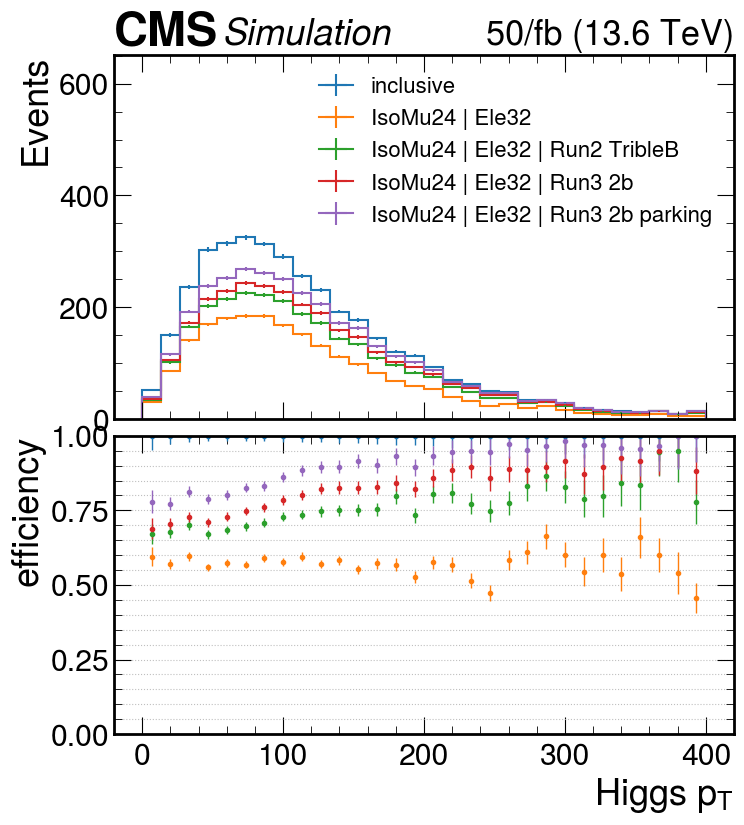

In [77]:
hist_comparison_2(df["variables"]["higgs_pt"]["ttHTobb"]["ttHTobb_Run3"], 
                ['semilep', 'semilep_singlelepHLT','semilep_tripleB+singleLep', 
                 'semilep_doubleB_tighter+singleLep', 'semilep_doubleB_looser+singleLep' ],
                 labels=["inclusive", "IsoMu24 | Ele32", "IsoMu24 | Ele32 | Run2 TribleB",
                        "IsoMu24 | Ele32 | Run3 2b", "IsoMu24 | Ele32 | Run3 2b parking"],
                  file="semilep_higgs_pt_or_singleLep",
                 output_folder="/eos/user/d/dvalsecc/www/ttHbbPlots/triggers_run3_plots")

/tmp/ipykernel_575/1484966975.py:36: RuntimeWarning: divide by zero encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/1484966975.py:36: RuntimeWarning: invalid value encountered in multiply
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/1484966975.py:36: RuntimeWarning: invalid value encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/1484966975.py:37: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


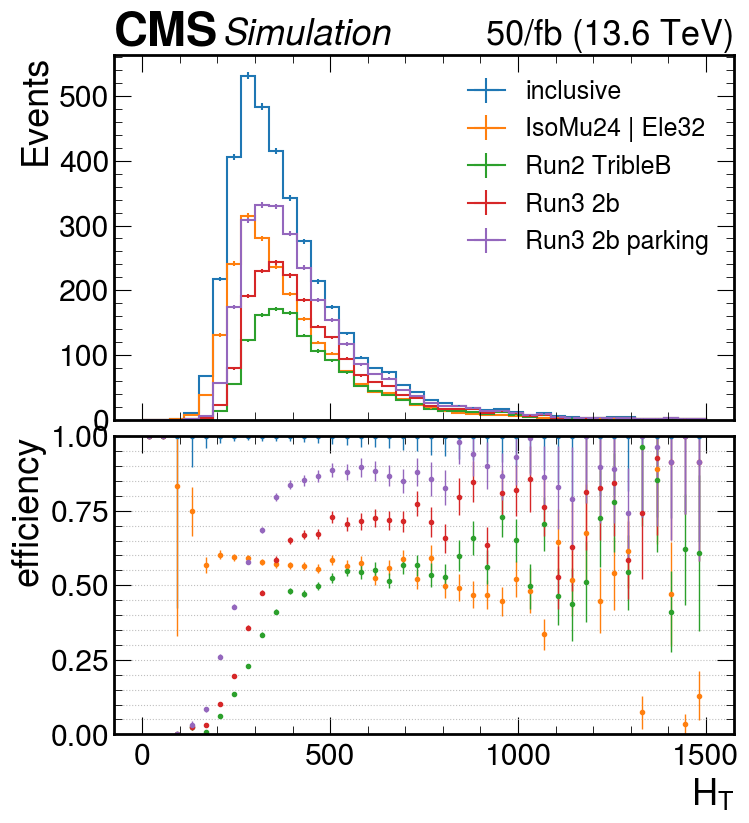

In [67]:
hist_comparison_2(df["variables"]["HT"]["ttHTobb"]["ttHTobb_Run3"], 
                ['semilep', 'semilep_singlelepHLT','semilep_tripleB', 
                 'semilep_doubleB_tighter', 'semilep_doubleB_looser' ],
                 labels=["inclusive", "IsoMu24 | Ele32", "Run2 TribleB",
                        "Run3 2b", "Run3 2b parking"],
                  file="semilep_HT",
                 output_folder="/eos/user/d/dvalsecc/www/ttHbbPlots/triggers_run3_plots")

/tmp/ipykernel_575/244087147.py:36: RuntimeWarning: divide by zero encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/244087147.py:36: RuntimeWarning: invalid value encountered in multiply
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/244087147.py:36: RuntimeWarning: invalid value encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/244087147.py:37: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


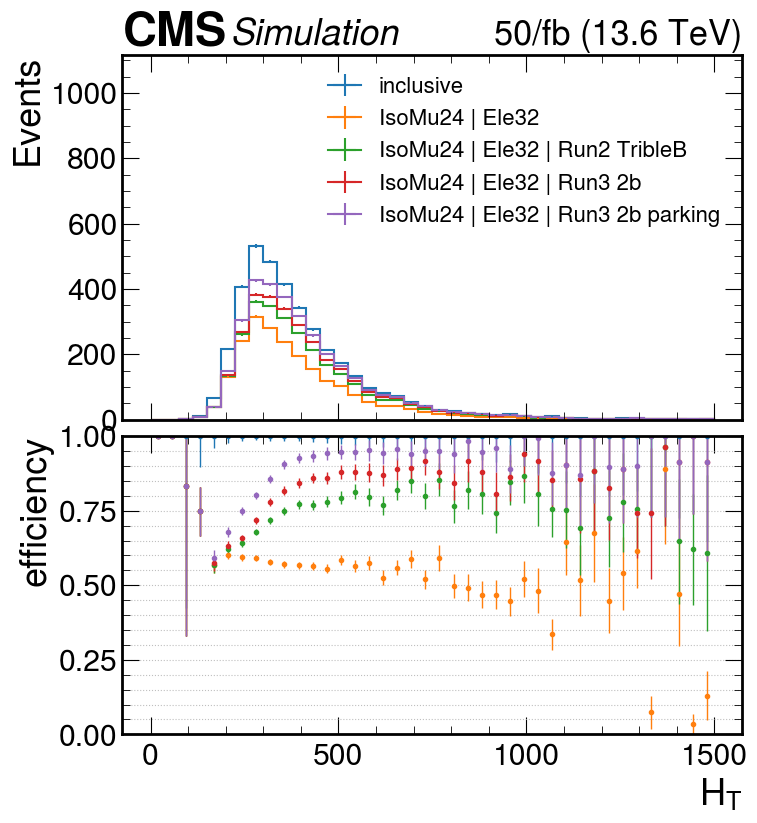

In [78]:
hist_comparison_2(df["variables"]["HT"]["ttHTobb"]["ttHTobb_Run3"], 
                ['semilep', 'semilep_singlelepHLT','semilep_tripleB+singleLep', 
                 'semilep_doubleB_tighter+singleLep', 'semilep_doubleB_looser+singleLep' ],
                 labels=["inclusive", "IsoMu24 | Ele32", "IsoMu24 | Ele32 | Run2 TribleB",
                        "IsoMu24 | Ele32 | Run3 2b", "IsoMu24 | Ele32 | Run3 2b parking"],
                  file="semilep_HT_or_singleLep",
                 output_folder="/eos/user/d/dvalsecc/www/ttHbbPlots/triggers_run3_plots")

/tmp/ipykernel_575/1484966975.py:36: RuntimeWarning: divide by zero encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/1484966975.py:36: RuntimeWarning: invalid value encountered in multiply
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/1484966975.py:36: RuntimeWarning: invalid value encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/1484966975.py:37: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


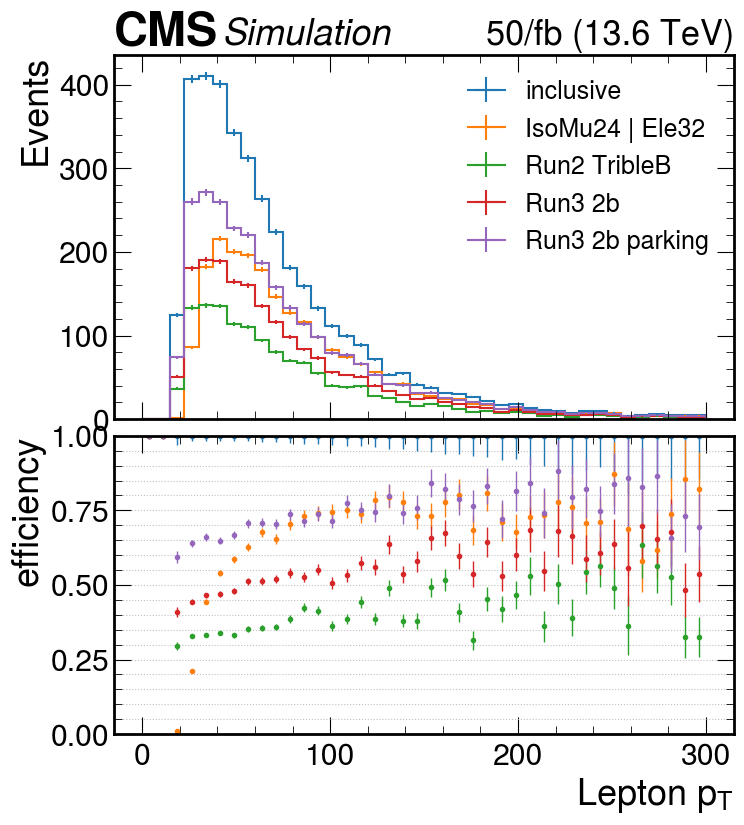

In [69]:
hist_comparison_2(df["variables"]["Lepton_pt"]["ttHTobb"]["ttHTobb_Run3"], 
                ['semilep', 'semilep_singlelepHLT','semilep_tripleB', 
                 'semilep_doubleB_tighter', 'semilep_doubleB_looser' ],
                 labels=["inclusive", "IsoMu24 | Ele32", "Run2 TribleB",
                        "Run3 2b", "Run3 2b parking"],
                  file="semilep_lepton_pt",
                 output_folder="/eos/user/d/dvalsecc/www/ttHbbPlots/triggers_run3_plots")

/tmp/ipykernel_575/244087147.py:36: RuntimeWarning: divide by zero encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/244087147.py:36: RuntimeWarning: invalid value encountered in multiply
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/244087147.py:36: RuntimeWarning: invalid value encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/244087147.py:37: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


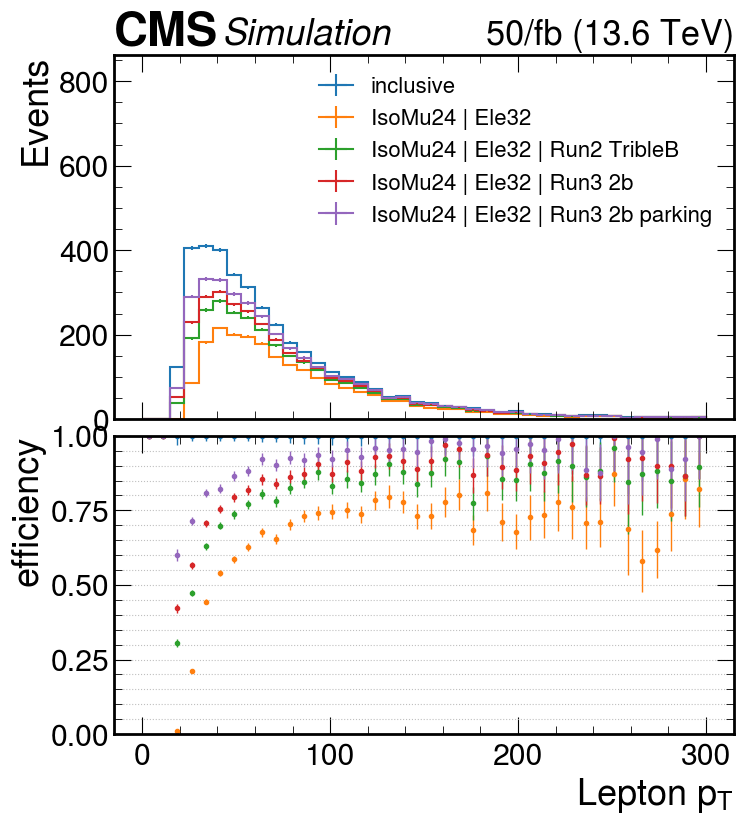

In [79]:
hist_comparison_2(df["variables"]["Lepton_pt"]["ttHTobb"]["ttHTobb_Run3"], 
                ['semilep', 'semilep_singlelepHLT','semilep_tripleB+singleLep', 
                 'semilep_doubleB_tighter+singleLep', 'semilep_doubleB_looser+singleLep' ],
                 labels=["inclusive", "IsoMu24 | Ele32", "IsoMu24 | Ele32 | Run2 TribleB",
                        "IsoMu24 | Ele32 | Run3 2b", "IsoMu24 | Ele32 | Run3 2b parking"],
                  file="semilep_leptonPt_or_singleLep",
                 output_folder="/eos/user/d/dvalsecc/www/ttHbbPlots/triggers_run3_plots")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


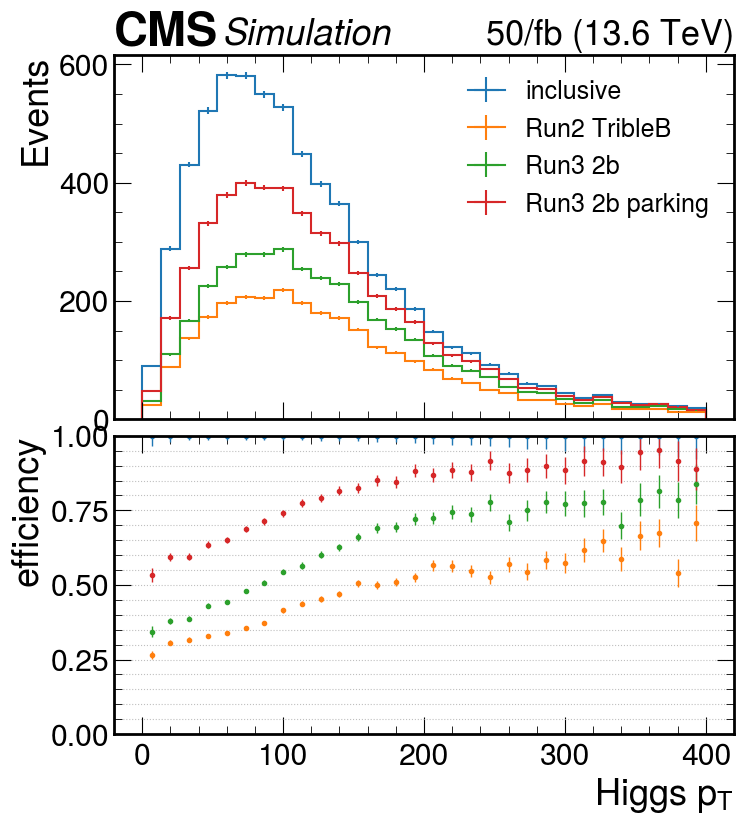

In [71]:
hist_comparison_2(df["variables"]["higgs_pt"]["ttHTobb"]["ttHTobb_Run3"], 
                ['had', 'had_tripleB', 'had_doubleB_tighter', 'had_doubleB_looser' ],
                 labels=["inclusive",  "Run2 TribleB",
                        "Run3 2b", "Run3 2b parking"],
                  file="fullhad_higgs_pt",
                 output_folder="/eos/user/d/dvalsecc/www/ttHbbPlots/triggers_run3_plots")

/tmp/ipykernel_575/1484966975.py:36: RuntimeWarning: divide by zero encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/1484966975.py:36: RuntimeWarning: invalid value encountered in multiply
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/1484966975.py:36: RuntimeWarning: invalid value encountered in divide
  err = np.sqrt((1/nomvalues)**2 * h_sig2 + (h_val/nomvalues**2)**2 * nom_sig2 )
/tmp/ipykernel_575/1484966975.py:37: RuntimeWarning: invalid value encountered in divide
  r = np.where(nomvalues>0,h.values() / nomvalues, 1.0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


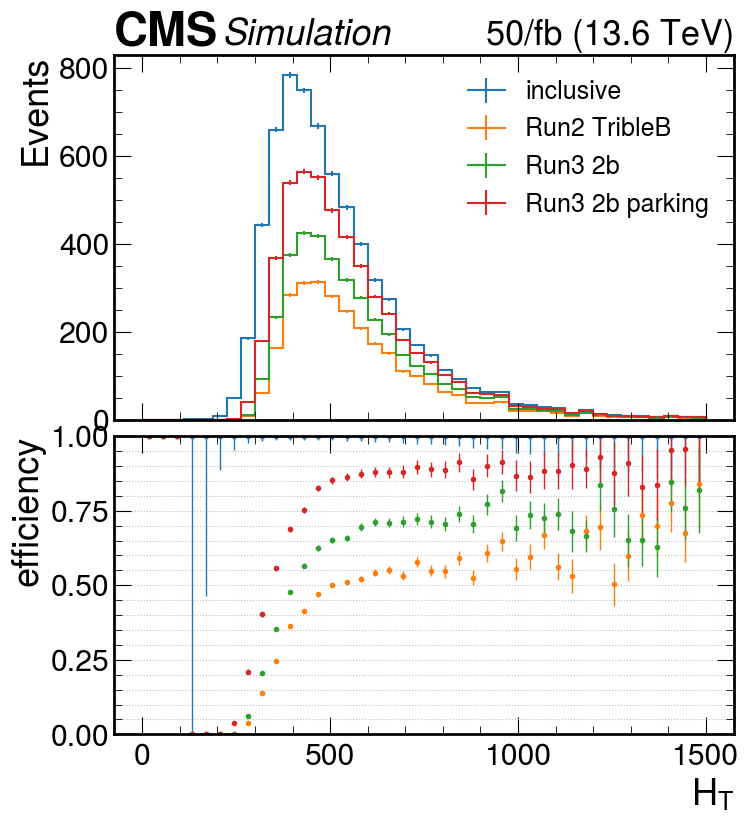

In [72]:
hist_comparison_2(df["variables"]["HT"]["ttHTobb"]["ttHTobb_Run3"], 
                ['had', 'had_tripleB', 'had_doubleB_tighter', 'had_doubleB_looser' ],
                 labels=["inclusive",  "Run2 TribleB",
                        "Run3 2b", "Run3 2b parking"],
                  file="fullhad_HT",
                 output_folder="/eos/user/d/dvalsecc/www/ttHbbPlots/triggers_run3_plots")